# Machine Learning

In [ ]:
# Basics
import pandas as pd 
import numpy as np

# Preprocessing
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler
)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

# from imblearn.over_sampling import SMOTE # for SMOTE procedure

## First models 

We are starting by testing multiple Machine Learning models on a cleaned simplified dataset.

Categorical => OneHotEncoder or one dimension with different values (1, 2, 3, 4, etc.)
- SEASON (4 classes)
- BASIN (7 classes)
- NATURE (6 classes)

Numeric => everything between 0 and 1
- LAT
- LON
- WIND 
- DIST2LAND
- STORM_SPEED
- STORM_DIR

### Choosing the pertient models

The different models can be found here :
https://scikit-learn.org/stable/machine_learning_map.html

| model | person | scores | encoding
| --- | --- | --- | --- | 
| Knn | Vincent | -- | OneHotEncoder/LabelBinarizer | 
| Knn | -- | -- | -- | 
| SVM | Vincent | -- | OneHotEncoder/LabelBinarizer | 
| SVM | -- | -- | -- | 
| Randomforest | Audrey | -- | OneHotEncoder/LabelBinarizer | 
| Randomforest | Audrey | -- | Categorical encoding | 
| LinearSVC | Arnaud | -- | OneHotEncoder/LabelBinarizer | 
| LinearSVC | Arnaud | -- | Categorical encoding | 
| -- | -- | -- | -- | 
| -- | -- | -- | -- | 
| -- | -- | -- | -- | 
| -- | -- | -- | -- | 
| -- | -- | -- | -- | 



The dataset can be imported with :

In [4]:
df = pd.read_parquet("data/base.parquet", engine="pyarrow")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45025 entries, 0 to 67409
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEASON        45025 non-null  object 
 1   BASIN         45025 non-null  object 
 2   NATURE        45025 non-null  object 
 3   LAT           45025 non-null  float64
 4   LON           45025 non-null  float64
 5   WIND          45025 non-null  float64
 6   DIST2LAND     45025 non-null  int64  
 7   STORM_SPEED   45025 non-null  float64
 8   STORM_DIR     45025 non-null  float64
 9   TD9636_STAGE  45025 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.8+ MB


<Axes: xlabel='STORM_DIR', ylabel='STORM_SPEED'>

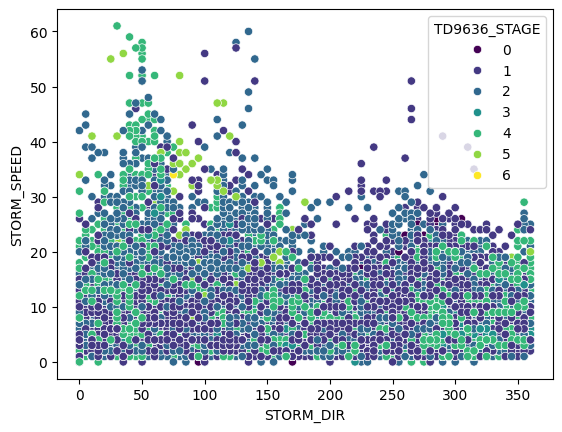

In [6]:
# plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    x = 'STORM_DIR',
    y = 'STORM_SPEED',
    data = df,
    hue = 'TD9636_STAGE',
    palette = 'viridis',
)

# Encoding
NATURE AND SEASON columns encoded with the creation of new binary columns to avoid giving weight to certain values.

For the SEASON column, we used the OrdinalEncoder() method to give more weight to seasons with more frequent and stronger storms.


In [52]:
# Encoding the NATURE column
DATA = pd.concat([df,
                 pd.get_dummies(df.NATURE)],axis=1).drop(columns='NATURE')
DATA = DATA.drop(columns='TS')
# We remove TS column (following K-1 rules)

# Same for BASIN
DATA = pd.concat([DATA,
                 pd.get_dummies(DATA.BASIN)],axis=1).drop(columns='BASIN')
DATA = DATA.drop(columns='WP')
# We remove WP column (following K-1 rules)



In [53]:
from sklearn.preprocessing import OrdinalEncoder
# Encoding the SEASON column
encoder = OrdinalEncoder(categories = [['Winter', 'Spring', 'Fall', 'Summer']]) 
DATA['SEASON'] = encoder.fit_transform(DATA[['SEASON']])

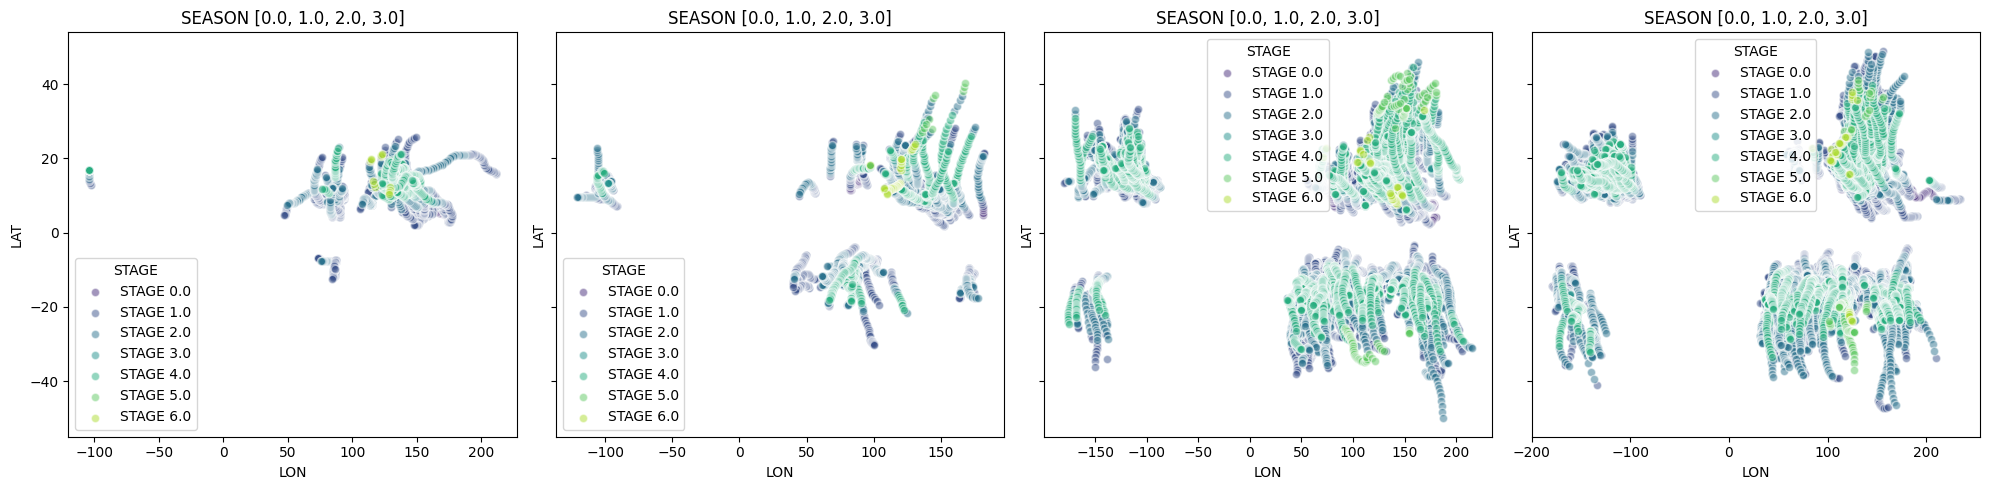

In [ ]:
# Plot storm stages based on the season

season = sorted(DATA['SEASON'].unique())
num_season = len(season)

stages = sorted(DATA['TD9636_STAGE'].unique())
num_stages = len(stages)

# Create subplots
fig, axes = plt.subplots(1, num_season, figsize=(5 * num_season, 5), sharey=True)

# If only one stage, make sure axes is iterable
if num_season == 1:
    axes = [axes]

# Define color palette
palette = sns.color_palette('viridis', len(stages))  
stage_colors = dict(zip(stages, palette))  # Map STAGE to colors

# Plot each stage separately
for axe, ss in zip(axes, season):
    subset = DATA[DATA['SEASON'] == ss]

    for stage in stages:
        stage_data = subset[subset['TD9636_STAGE'] == stage]
        axe.scatter(stage_data['LON'], stage_data['LAT'], 
                    color=stage_colors[stage], 
                    label=f'STAGE {stage}', 
                    alpha=0.5, edgecolors='w')

        axe.set_title(f'SEASON {season}')
        axe.set_xlabel('LON')
        axe.set_ylabel('LAT')
        axe.legend(title='STAGE')



plt.tight_layout()
plt.show()

# storms also seem to be stronger in the northwest pacific

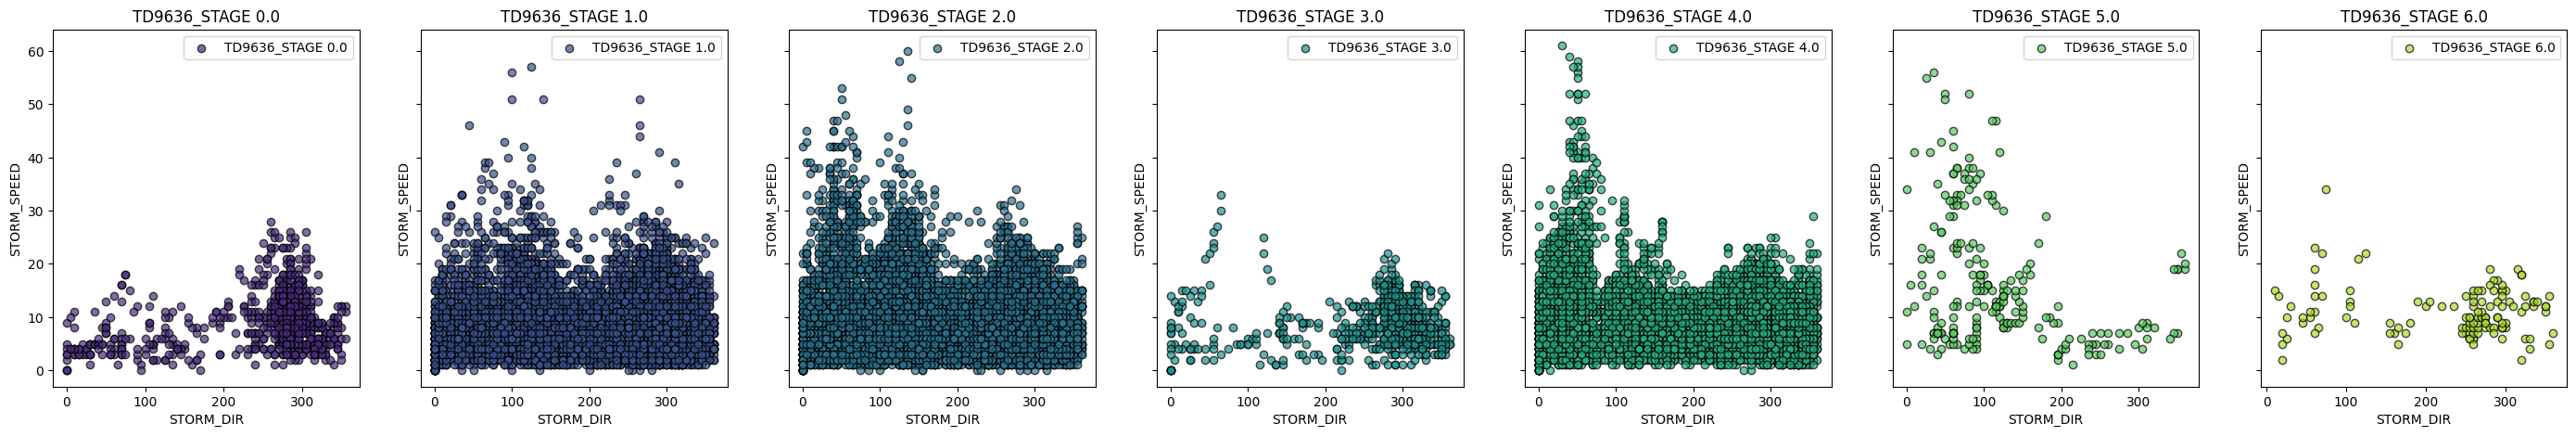

In [ ]:
# Plot each stage separately as the number of points is too high and we don't see anything on the previous plot

stages = sorted(df['TD9636_STAGE'].unique())
num_stages = len(stages)

# Create subplots
fig, axes = plt.subplots(1, num_stages, figsize=(5 * num_stages, 5), sharey=True)

# If only one stage, make sure axes is iterable
if num_stages == 1:
    axes = [axes]

# Define color palette
palette = sns.color_palette('viridis', num_stages)

# Plot each stage separately
for axe, stage, color in zip(axes, stages, palette):
    subset = df[df['TD9636_STAGE'] == stage]
    axe.scatter(subset['STORM_DIR'], subset['STORM_SPEED'], color=color, label=f'TD9636_STAGE {stage}', alpha=0.7, edgecolors='w')
    axe.set_title(f'TD9636_STAGE {stage}')
    axe.set_xlabel('STORM_DIR')
    axe.set_ylabel('STORM_SPEED')
    axe.legend()

plt.tight_layout()
plt.show()

# The number of data is very unbalanced

#### Spliting the dataset into training and testing subset 
We used 80 % for training and 20 % for testing

In [ ]:
# creation of the training and test datasets
DATA_train, DATA_test = train_test_split(DATA ,test_size = 0.2)

DATA_train.TD9636_STAGE.value_counts().sort_index()
DATA_test.TD9636_STAGE.value_counts().sort_index()

# get the values of the columns for the training data
X_train = DATA_train.drop(columns='TD9636_STAGE')
y_train = DATA_train['TD9636_STAGE']

# get the values of the columns for the test data
X_test = DATA_test.drop(columns='TD9636_STAGE')
y_test = DATA_test['TD9636_STAGE']

TD9636_STAGE
0.0     187
1.0    3110
2.0    3375
3.0     149
4.0    2114
5.0      46
6.0      24
Name: count, dtype: int64

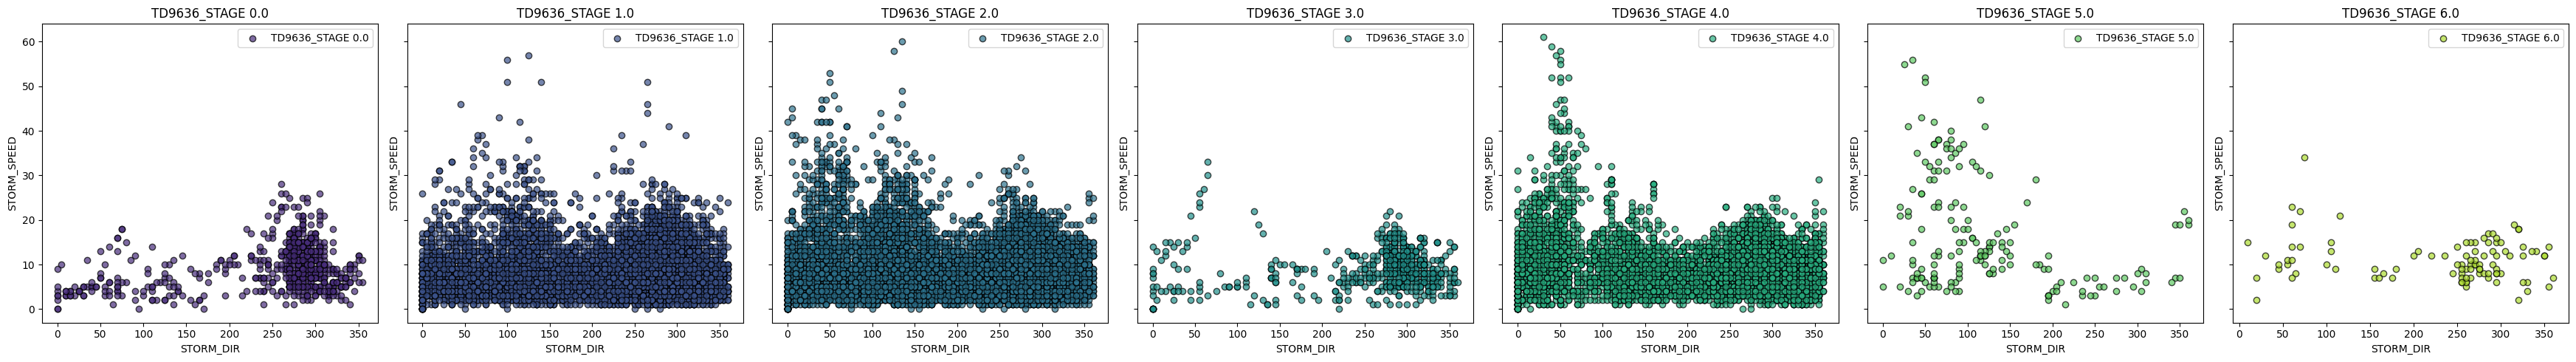

In [ ]:
# Redo the plot with the training data just to have a look to what we have

stages = sorted(DATA_train['TD9636_STAGE'].unique())
num_stages = len(stages)

# Create subplots
fig, axes = plt.subplots(1, num_stages, figsize=(5 * num_stages, 5), sharey=True)

# If only one stage, make sure axes is iterable
if num_stages == 1:
    axes = [axes]

# Define color palette
palette = sns.color_palette('viridis', num_stages)

# Plot each stage separately
for axe, stage, color in zip(axes, stages, palette):
    subset = DATA_train[DATA_train['TD9636_STAGE'] == stage]
    axe.scatter(subset['STORM_DIR'], subset['STORM_SPEED'], color=color, label=f'TD9636_STAGE {stage}', alpha=0.7, edgecolors='w')
    axe.set_title(f'TD9636_STAGE {stage}')
    axe.set_xlabel('STORM_DIR')
    axe.set_ylabel('STORM_SPEED')
    axe.legend()

# adjust 
plt.tight_layout()
plt.show()

#### Scalling and Normalizing

 \\\\\ I forget to do it ////

In [74]:
# Try an ensemble classifier: Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier()
rf_model.fit(X=X_train,y=y_train)
y_test_predicted_rf = rf_model.predict(X_test)
report_rf = classification_report(y_pred=y_test_predicted_rf,y_true=y_test)

print(report_rf)


              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       187
         1.0       0.94      0.93      0.93      3110
         2.0       0.91      0.93      0.92      3375
         3.0       0.78      0.47      0.59       149
         4.0       0.94      0.95      0.94      2114
         5.0       0.94      0.70      0.80        46
         6.0       1.00      0.58      0.74        24

    accuracy                           0.92      9005
   macro avg       0.92      0.79      0.84      9005
weighted avg       0.92      0.92      0.92      9005

